In [1]:
from string import ascii_uppercase

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

In [2]:
# Load the CSV file into a pandas DataFrame
adult_df = pd.read_csv('./data/adult.csv')

In [3]:
adult_df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,189778.366512,10.080679,1077.648844,87.303830,40.437456
std,13.640433,105549.977697,2.572720,7385.292085,402.960219,12.347429
min,17.000000,12285.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,117827.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,178356.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,237051.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,1484705.000000,16.000000,99999.000000,4356.000000,99.000000


In [4]:
adult_df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [5]:
# We need to replace the incomes with an integer that denotes its class
adult_df['income'] = np.where(adult_df['income'] == '>50K', 1, 0)

In [6]:
# Define a function to visualize how the different columns correlate with the income
def hist_by(df, column):
    X, y = [], []
    for value in sorted(df[column].unique()):
        X.append(value)
        y.append(df[df[column] == value]['income'].mean() * 100.0)

    index = np.arange(len(X))
    width = 0.35
    plt.bar(index, y, width)
    plt.xticks(index+width/2, X, rotation=70)
    plt.yticks(np.arange(0, 100, 10))
    plt.ylim(0, 100)
    plt.xlabel(column)
    plt.ylabel('Percentage of people who\'s income is above $50K')
    plt.tight_layout()
    plt.show()

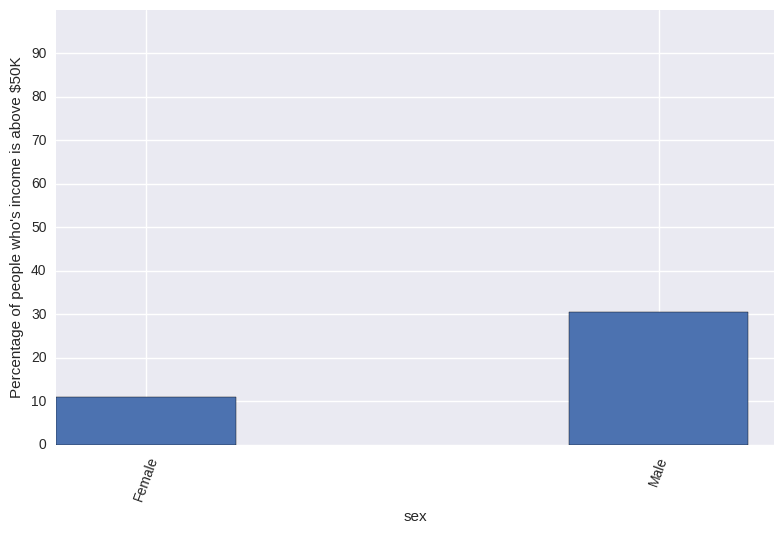

In [7]:
# Visualize how the sex correlates with the income
hist_by(adult_df, 'sex')

According the data, 10% of women have incomes above \$50K. 30% of men have incomes above \$50K.

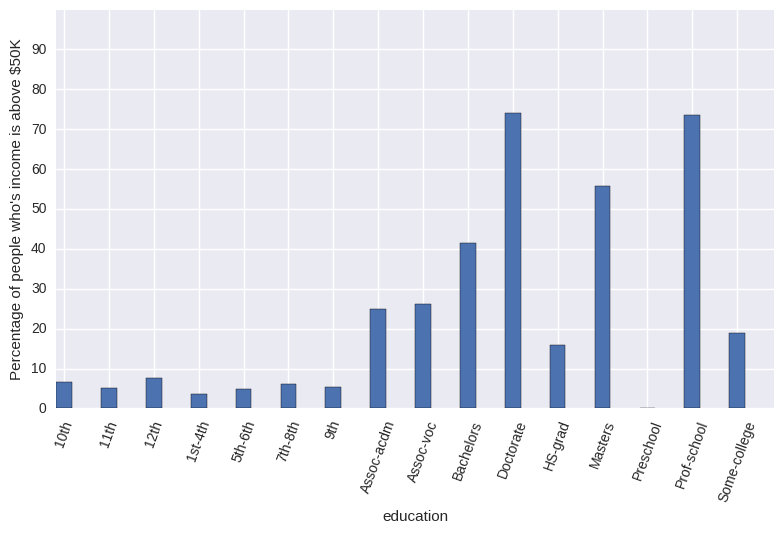

In [8]:
# Visualize how an educational degree correlates with the income
hist_by(adult_df, 'education')

Professors and doctorate holders are more likely to have incomes above $50K.

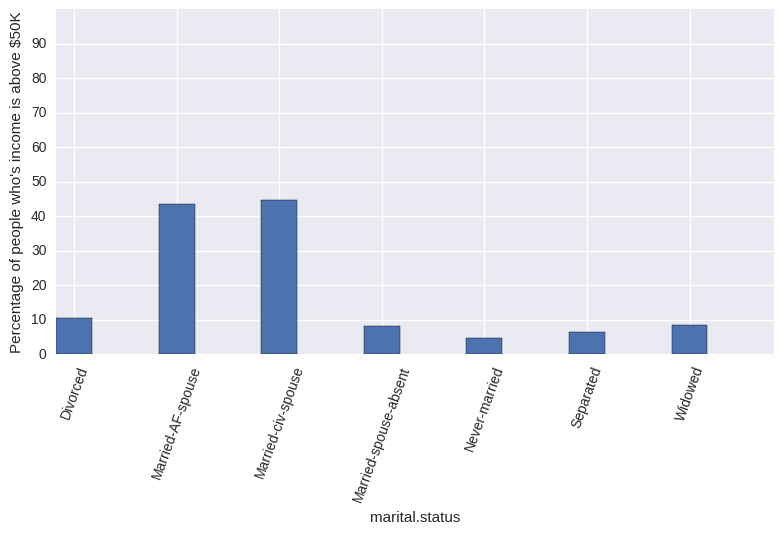

In [9]:
# Visualize how marital status is related to income
hist_by(adult_df, 'marital.status')

Married people tend to have higher incomes

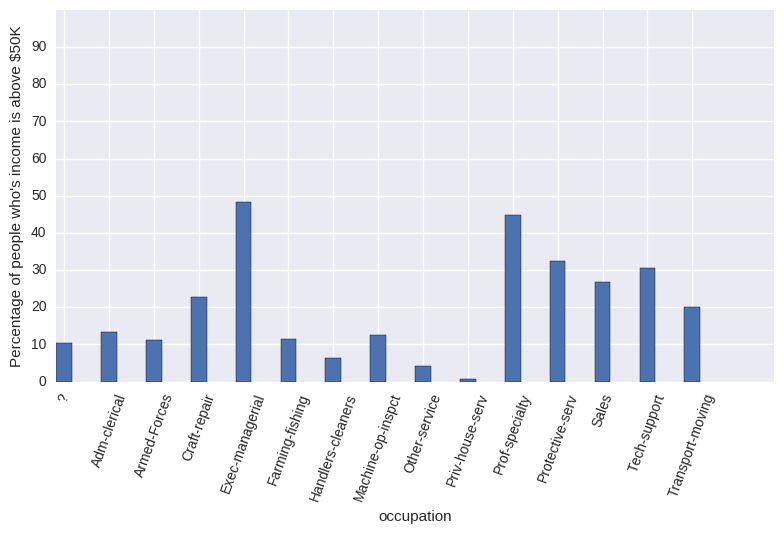

In [10]:
# Visualize how occupation correlates with income
hist_by(adult_df, 'occupation')

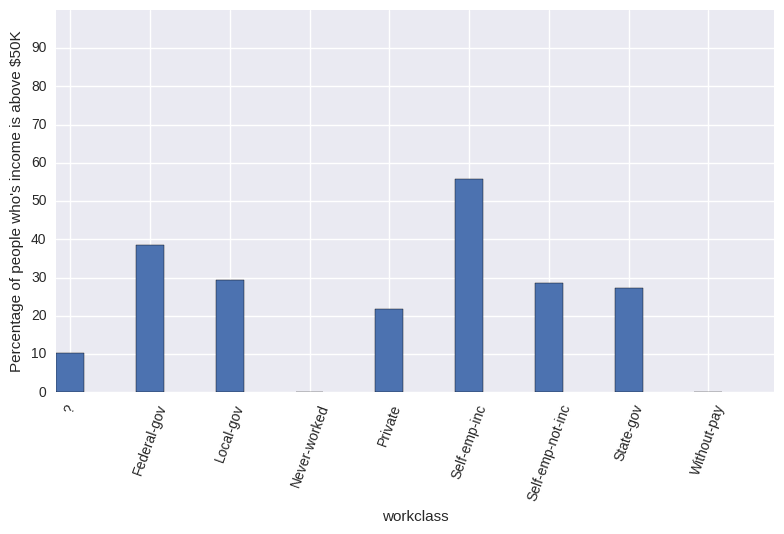

In [11]:
# Visualize how workclass correlates with income
hist_by(adult_df, 'workclass')

In [12]:
# Get rid of the entries where the occupation or workclass is unknown
adult_df = adult_df[adult_df['occupation'] != '?']
adult_df = adult_df[adult_df['workclass'] != '?']

In [13]:
# Get the dummies for the columns. This is the same as LabelBinarizer in sklearn
education_dummies = pd.get_dummies(adult_df['education'])
marital_dummies = pd.get_dummies(adult_df['marital.status'])
relationship_dummies = pd.get_dummies(adult_df['relationship'])
sex_dummies = pd.get_dummies(adult_df['sex'])
occupation_dummies = pd.get_dummies(adult_df['occupation'])
native_dummies = pd.get_dummies(adult_df['native.country'])
race_dummies = pd.get_dummies(adult_df['race'])
workclass_dummies = pd.get_dummies(adult_df['workclass'])

In [14]:
# Example: for marital status
marital_dummies.head()

,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
1,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0
5,1,0,0,0,0,0,0
6,0,0,0,0,0,1,0


In [15]:
# Define a function to put the continuous values in bins
def into_bins(column, bins):
    group_names = list(ascii_uppercase[:len(bins)-1])
    binned = pd.cut(column, bins, labels=group_names)
    return binned

In [16]:
# Let's see how the capital loss varies
adult_df['capital.loss'].describe()

count    30718.000000
mean        88.910216
std        405.657203
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital.loss, dtype: float64

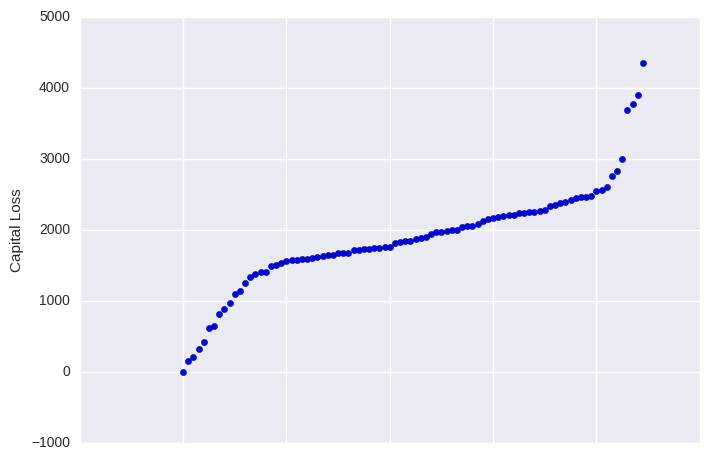

In [17]:
# Create a scatter plot of all the unique values in capital.loss.
# This will be helpful in visualizing how to assign bins to this feature
unique = sorted(adult_df['capital.loss'].unique())
plt.scatter(range(len(unique)), unique)
plt.ylabel('Capital Loss')
plt.tick_params(axis='x', which='both', labelbottom='off', bottom='off') # disable x ticks
plt.show()

In [18]:
# Create bins from -1 to 4500, with 500 values in each bin
loss_bins = into_bins(adult_df['capital.loss'], list(range(-1, 4500, 500)))
loss_dummies = pd.get_dummies(loss_bins)

In [19]:
# Let's see how the capital gain varies
adult_df['capital.gain'].describe()

count    30718.000000
mean      1106.037079
std       7497.863364
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital.gain, dtype: float64

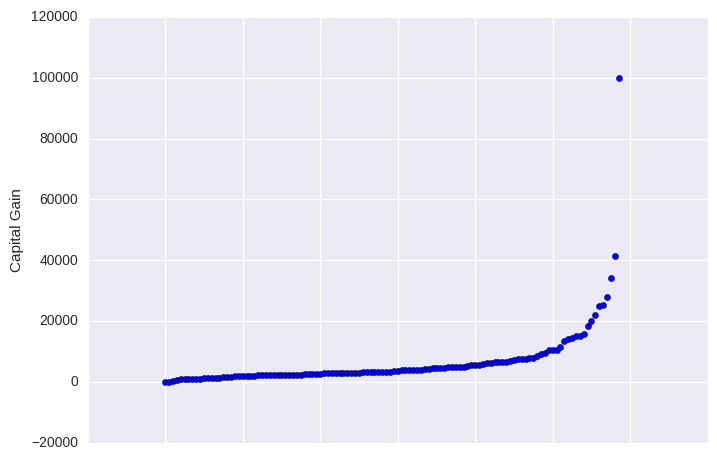

In [20]:
# Create a scatter plot of all the unique values in capital.gain.
# This will be helpful in visualizing how to assign bins to this feature
unique = sorted(adult_df['capital.gain'].unique())
plt.scatter(range(len(unique)), unique)
plt.ylabel('Capital Gain')
plt.tick_params(axis='x', which='both', labelbottom='off', bottom='off') # disable x ticks
plt.show()

In [21]:
# Create bins from -1 to 42000, with 5000 values in each bin. And an extra one for the outlier
gain_bins = into_bins(adult_df['capital.gain'], list(range(-1, 42000, 5000)) + [100000])
gain_dummies = pd.get_dummies(gain_bins)

In [22]:
# Concatenate all the columns we need and the ones we generated by binning and creating dummies
X = pd.concat([adult_df[['age', 'hours.per.week']], gain_dummies, occupation_dummies, workclass_dummies, education_dummies, marital_dummies, race_dummies, sex_dummies], axis=1)
y = adult_df['income']

# Create test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=1)

In [23]:
# Create a classifier and fit the data
clf = AdaBoostClassifier(random_state=1)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=1)

In [24]:
# Find accuracy using the test set
y_pred = clf.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(y_pred, y_test)))

Accuracy: 0.8414713541666666
